In [15]:
from __future__ import division
import pandas as pd
import numpy as np
import numpy as np
from matplotlib import pyplot as plt
from numpy.linalg import inv,pinv
from scipy.optimize import minimize
import sys

In [16]:
TEST_DIR = 'train_valid/'
PRED_DIR = 'pred/valid/'
csv_list=[]
name_list=['AR_valid.csv','BAH_valid.csv','FTI_valid.csv','HII_valid.csv','LMT_valid.csv','MLI_valid.csv','NFE_valid.csv','NOC_valid.csv','PBR_valid.csv','STLD_valid.csv']
for i in name_list:
    dt = pd.read_csv(TEST_DIR+i, index_col=5).iloc[: , 1:]
    dt = dt[~dt.index.duplicated()]
    dt = dt['return']
    dt.name = i[:-4]
    csv_list.append(dt)

#all the test data
result = pd.concat(csv_list, axis=1)
result= result.dropna(axis=0,how='any')

In [17]:
csv_pred_list=[]
name_pred_list=['AR_pred.csv','BAH_pred.csv','FTI_pred.csv','HII_pred.csv','LMT_pred.csv','MLI_pred.csv','NFE_pred.csv','NOC_pred.csv','PBR_pred.csv','STLD_pred.csv',]
for i in name_pred_list:
    dt_pred = pd.read_csv(PRED_DIR+i, index_col=0)
    dt_pred = dt_pred['Predict_return']
    dt_pred = dt_pred[~dt_pred.index.duplicated()]
    dt_pred.name = i[:-4]
    csv_pred_list.append(dt_pred)

result_pred = pd.concat(csv_pred_list, axis=1)
result_pred= result_pred.dropna(axis=0,how='any')

In [18]:
#some are nan because the first 120min are used to predict or missing data
align_df = pd.concat([result,result_pred], axis=1).reset_index(drop=True)
df_test = align_df.dropna(axis=0,how='any').iloc[:,:10]
df_pred_test = align_df.dropna(axis=0,how='any').iloc[:,10:]
result = align_df.iloc[:,:10]
result_pred= align_df.iloc[:,10:]

## Sharpe Ratio-Squared-weighted risk contributions portfolio(with covariance)

In [19]:
# risk budgeting optimization
def calculate_portfolio_var(w,V):
    # function that calculates portfolio risk
    w = np.matrix(w)
    return (w*V*w.T)[0,0]

def calculate_risk_contribution(w,V):
    # function that calculates asset contribution to total risk
    w = np.matrix(w)
    sigma = np.sqrt(calculate_portfolio_var(w,V))
    # Marginal Risk Contribution
    MRC = V*w.T
    # Risk Contribution
    RC = np.multiply(MRC,w.T)/sigma
    return RC

def risk_budget_objective(x,pars):
    # calculate portfolio risk
    V = pars[0]
    x_t = pars[1]
    sig_p =  np.sqrt(calculate_portfolio_var(x,V)) # portfolio sigma
    risk_target = np.asmatrix(np.multiply(sig_p,x_t))
    asset_RC = calculate_risk_contribution(x,V)
    J = sum(np.square(asset_RC-risk_target.T))[0,0] # sum of squared error
    return J

def total_weight_constraint(x):
    return np.sum(x)-1.0

def risk_alloc_adjust(V, r, r_0 = 4.019129019129019e-07):
    r_0_list = np.array([ r_0 for i in range(len(r))])
    std = np.sqrt(np.diagonal(V))
    denom = np.sum(((r - r_0_list)/std)**2)
#     print(denom)
    x_t = ((r - r_0_list)/std)/denom
    return x_t


In [20]:
def profile_return_with_different_num_alphanet(choose_n, df_pred_test, result, df_test):
    """
    the return of profile
    :param choose_n: the number of stack chosen
    :param df_pred_test: the predicted return of alpha net in test set
    :param result: all the test set
    :param df_test: the true return of alpha net in test set
    :return:
    """
    weight = 1/choose_n
    res_all=[]
    res_all_stock_name=[]
    for j in range(df_pred_test.shape[0]):
        top_n = df_pred_test.iloc[[j]]
        top_n = top_n.iloc[0].nlargest(choose_n).to_frame().T
        list_pred_keep=list(top_n.columns)
        list_real_keep=[]
        for i in list_pred_keep:
            list_real_keep.append(i[:-4]+'valid')
        res_all_stock_name.append(list_real_keep)
#         print(list_real_keep)
        df_real = result[result.columns[result.columns.isin(list_real_keep)]]
#         print(df_real)
        df_pred = df_pred_test[df_pred_test.columns[df_pred_test.columns.isin(list_pred_keep)]]
        #print(df_pred)
        cov_index = df_pred_test.iloc[[j],:].index[0]
        df=df_real.iloc[max(cov_index-120,0):cov_index]
        V= df.cov()
#         print(V)
        V = np.matrix(V)
        r = df_pred.iloc[j]
        r = np.stack(r.values)
        # initialization
        w0 = [weight]*choose_n
        # risk budget percent of total portofolio risk
        x_t = risk_alloc_adjust(V, r, r_0 = 4.019129019129019e-07)
        cons = ({'type': 'eq', 'fun': total_weight_constraint})
        res= minimize(risk_budget_objective, w0, args=[V,x_t], method='SLSQP',constraints=cons, tol=1e-15, options={'disp': False})
        flag=0
        res_zero=[0]*choose_n
        for i in df_pred.iloc[j]:
            if i>0:
                flag=1
        if flag==1:
            res_all.append(res.x)
        else:
            res_all.append(res_zero)

    res_sum=[1]
    res_ratio=[]
    for i in range(len(res_all)):
        r = np.sum(df_test[res_all_stock_name[i]].iloc[i]*res_all[i])
        res_ratio.append(r)
        res_sum.append(res_sum[-1]*(1+r))

    return choose_n, res_sum, res_ratio

In [21]:
#from the result of validation set, we choose 5 stocks.
res_num=[]
for i in range(7,11):
    print(f"{i} stocks situation is processing")
    res_num.append(profile_return_with_different_num_alphanet(i, df_pred_test, result, df_test))

7 stocks situation is processing
8 stocks situation is processing
9 stocks situation is processing
10 stocks situation is processing


In [22]:
res_ratio=[]
for i in range(len(res_num)):
    list_res=res_num[i][2]
    res_ratio.append(list_res)

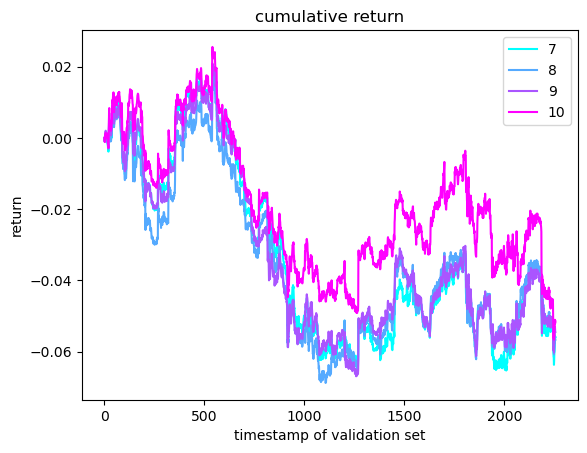

In [24]:
x = range(len(res_num[0][1]))
colorlist=plt.cm.cool(np.linspace(0,1,len(res_num)))
for i in range(len(res_num)):
    plt.plot(x,np.array(res_num[i][1])-1,color=colorlist[i],label = res_num[i][0])
plt.title('cumulative return')
plt.xlabel("timestamp of validation set")
plt.ylabel("return")
plt.legend()

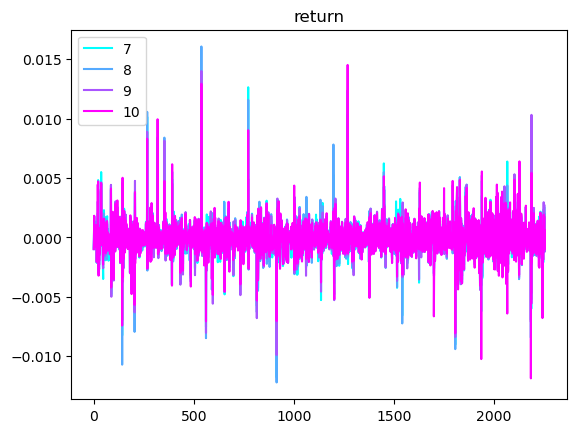

In [25]:
x = range(len(res_ratio[0]))
colorlist=plt.cm.cool(np.linspace(0,1,len(res_ratio)))
for i in range(len(res_ratio)):
    plt.plot(x,res_ratio[i],color=colorlist[i],label = res_num[i][0])
plt.title('return')
plt.legend()

# calculating metrics

from the result of validation set, we choose 10 stocks.

In [26]:
def valid_return(accumulated_return):
    '''
    input: accumulated valid set return for the strategy
    output: annual valid return
    '''
    month_return = accumulated_return.pop()
    annual_return = month_return**(12/2) - 1
    return annual_return

In [27]:
def valid_volatility(return_rate,frequency):
    '''
    frequency: the trading minute per day we get
    input: every minute valid set return for the strategy, type:list
    output: annual valid volatility
    '''
    annual_vola = np.std(return_rate) * np.sqrt(frequency*252)
    return annual_vola

In [28]:
valid_return(res_num[-1][1])

-0.2718550316875077

In [29]:
#when calculating the volatility, which could be influenced by record frequency dramatically,
#so we use the estimated daily return to estimate
#trading day: 20*2
frequency = int(len(df_pred_test)/40)
valid_volatility(res_num[-1][2],frequency)

0.16803260385351967

In [30]:
#sharp ratio
#0.0395 is the risk-free rate
(valid_return(res_num[-1][1])-0.0395)/valid_volatility(res_num[-1][2],frequency)

-1.8684076460811092